In [1]:
import torch
from torch import nn, optim
from torchsummary import summary
import torchvision
import numpy as np
import torchvision.transforms as T
import matplotlib.pyplot as plt
import os
from torch.utils.tensorboard import SummaryWriter
from torch.utils import tensorboard
from torchvision.models import resnet18
import zipfile
import glob
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

Device: cuda:0


In [3]:
print(torch.cuda.device_count())

1


In [4]:
augs = T.Compose([
    T.RandomRotation(degrees = 20),
    T.Resize((224,224)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

test_augs=  T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

In [5]:
img_files = os.listdir('data/train/train')
def train_path(p):
    return f"data/train/train/{p}"

img_files = list(map(train_path, img_files))
random.shuffle(img_files)

train = img_files[:20000]
val = img_files[20000:]

for i in range(100):
    print(train[i])

class CatDogDataset(Dataset):
    def __init__(self, image_paths, transform):
        super().__init__()
        self.paths = image_paths
        self.len = len(self.paths)
        self.transform = transform

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        path = self.paths[index]
        image = Image.open(path).convert('RGB')
        image = self.transform(image)
        label = 0 if 'cat' in path else 1
        return (image, label)

data/train/train/cat.9966.jpg
data/train/train/cat.3065.jpg
data/train/train/dog.1044.jpg
data/train/train/cat.7219.jpg
data/train/train/dog.3834.jpg
data/train/train/dog.12013.jpg
data/train/train/dog.9644.jpg
data/train/train/dog.1333.jpg
data/train/train/cat.12271.jpg
data/train/train/cat.7129.jpg
data/train/train/cat.5191.jpg
data/train/train/cat.3242.jpg
data/train/train/dog.324.jpg
data/train/train/cat.5093.jpg
data/train/train/dog.6009.jpg
data/train/train/dog.10032.jpg
data/train/train/cat.2278.jpg
data/train/train/cat.3543.jpg
data/train/train/cat.6920.jpg
data/train/train/dog.10303.jpg
data/train/train/cat.1409.jpg
data/train/train/dog.3557.jpg
data/train/train/cat.8860.jpg
data/train/train/cat.11694.jpg
data/train/train/cat.4551.jpg
data/train/train/cat.12058.jpg
data/train/train/dog.5218.jpg
data/train/train/dog.11765.jpg
data/train/train/dog.7546.jpg
data/train/train/cat.1893.jpg
data/train/train/dog.7254.jpg
data/train/train/cat.11011.jpg
data/train/train/cat.8444.jpg
dat

In [6]:
train_data = CatDogDataset(train, augs)
val_data = CatDogDataset(val, test_augs)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)


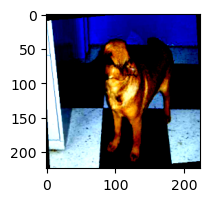

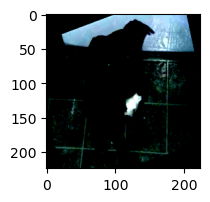

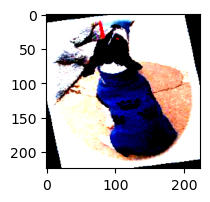

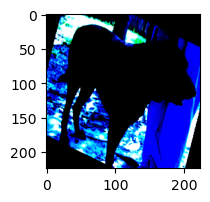

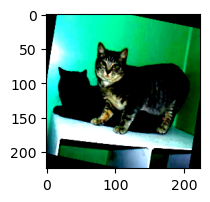

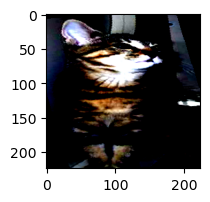

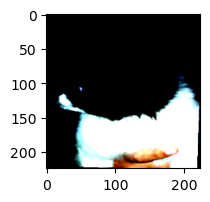

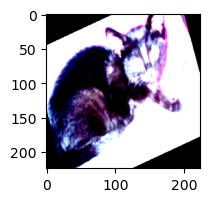

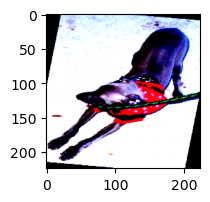

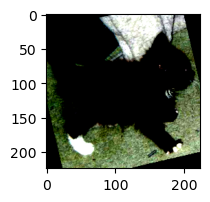

In [7]:
def imshow(img):
    plt.figure(figsize=(2,2))
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))

dataiter = iter(train_loader)
images, labels = next(dataiter)

for i in range(10):
    print(labels[i])
    imshow(torchvision.utils.make_grid(images[i]))

In [8]:
class ResBlock(nn.Module):

    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=(1,1), stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.layer(ResBlock, 64, num_blocks=2, stride=1)
        self.layer2 = self.layer(ResBlock, 128, num_blocks=2, stride=2)
        self.layer3 = self.layer(ResBlock, 256, num_blocks=2, stride=2)
        self.layer4 = self.layer(ResBlock, 512, num_blocks=2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(512,2),
            nn.Softmax(-1)
        )

    def layer(self, block, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc(x)

        return x

model = ResNet18()
model.to(device)
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
         ResBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [9]:
optimizer = optim.SGD(model.parameters(), momentum = 0.9, lr = 0.01, weight_decay=1e-5)
loss_func = nn.CrossEntropyLoss(reduction = 'mean')
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 4,verbose = True, min_lr = 0.00001)
num_epochs = 200

In [10]:
train_acc_list = []
val_acc_list = []

train_loss_list = []
val_loss_list = []

es_count = 0 # Patience for LR scheduler
curr_epoch = 0
curr_loss = 0
best_val_acc = 0
best_epoch = 0

for epoch in range(num_epochs):
    curr_epoch = epoch
    if es_count == 20:
        print("Stop training")
        break
    model.train()
    train_loss = 0
    train_acc = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        accuracy = (torch.max(outputs, dim=-1, keepdim=True)[1].flatten() == labels).sum() / len(labels)
        train_acc += accuracy.item()

    train_acc /= len(train_loader)
    train_loss /= len(train_loader)
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)

    model.eval()

    val_acc = 0
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            val_loss += loss.item()
            accuracy = (torch.max(outputs, dim=-1, keepdim=True)[1].flatten() == labels).sum() / len(labels)
            val_acc += accuracy.item()

        val_acc /= len(val_loader)
        val_loss /= len(val_loader)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

        if val_acc > best_val_acc:
            best_epoch = epoch
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")

    scheduler.step(val_loss)

    if abs(val_loss - curr_loss) < 0.005 or val_loss > curr_loss:
        es_count += 1
        curr_loss = val_loss
    else:
        es_count = 0
        curr_loss = val_loss

    print(f"Epoch {epoch + 1}/{num_epochs} - Training Acc: {train_acc:.4f} - Validation Acc: {val_acc:.4f}")


Epoch 1/200 - Training Acc: 0.6708 - Validation Acc: 0.7219
Epoch 2/200 - Training Acc: 0.7674 - Validation Acc: 0.7917
Epoch 3/200 - Training Acc: 0.8098 - Validation Acc: 0.8147
Epoch 4/200 - Training Acc: 0.8338 - Validation Acc: 0.8481
Epoch 5/200 - Training Acc: 0.8570 - Validation Acc: 0.8722
Epoch 6/200 - Training Acc: 0.8645 - Validation Acc: 0.8392
Epoch 7/200 - Training Acc: 0.8792 - Validation Acc: 0.9017
Epoch 8/200 - Training Acc: 0.8929 - Validation Acc: 0.8991
Epoch 9/200 - Training Acc: 0.8991 - Validation Acc: 0.9132
Epoch 10/200 - Training Acc: 0.9081 - Validation Acc: 0.8710
Epoch 11/200 - Training Acc: 0.9169 - Validation Acc: 0.8732
Epoch 12/200 - Training Acc: 0.9226 - Validation Acc: 0.9053
Epoch 13/200 - Training Acc: 0.9217 - Validation Acc: 0.9252
Epoch 14/200 - Training Acc: 0.9278 - Validation Acc: 0.9150
Epoch 15/200 - Training Acc: 0.9293 - Validation Acc: 0.9306
Epoch 16/200 - Training Acc: 0.9367 - Validation Acc: 0.9345
Epoch 17/200 - Training Acc: 0.93

KeyboardInterrupt: 

In [11]:

train_loss_list = np.array(train_loss_list)
val_loss_list = np.array(val_loss_list)
train_acc_list = np.array(train_acc_list)
val_acc_list = np.array(val_acc_list)

writer = SummaryWriter()

best_model = ResNet18()
best_model.load_state_dict(torch.load("best_model.pth"))
best_model.to(device)

writer.flush()
for i in range(curr_epoch):
    writer.add_scalars('Loss', {'Train': train_loss_list[i], 'Test': val_loss_list[i]}, i)
    writer.add_scalars('Accuracy', {'Train': train_acc_list[i], 'Test': val_acc_list[i]}, i)

writer.close()
